FF aan gabe vragen morgen, waarom wij geen waardes voor RfR krijgen, waardoor al die convergence shit niet werkt en we een andere problem formulation moeten gebruiken

In [1]:
# import all modules, some might not be necessary (DIE NOG VERWIJDEREN)
from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
    Constraint,
)
from ema_workbench.em_framework.optimization import EpsilonProgress, epsilon_nondominated
from ema_workbench.util import ema_logging

from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem, ArchiveLogger
from custom_problem_formulation_no_RfR import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd


In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

model, steps = get_model_for_problem_formulation()
problem = to_problem(model, searchover="levers")

In [70]:
# load the selected scenarios
scenarios_df = pd.read_csv('results/selected_scenarios.csv')
scenarios_df.rename(columns={'Unnamed: 0': 'scenario_id'}, inplace=True)
scenarios_df = scenarios_df.set_index('scenario_id')
scenarios_df

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
scenario_id,,,,,,,,,,,,,,,,,,,
12275,26,210.807918,1.5,0.092027,172.374261,1.5,0.517100,254.006564,1.0,0.915031,165.440227,10.0,0.235617,183.021862,10.0,0.342190,2.5,1.5,3.5
39833,101,123.723596,10.0,0.087285,315.055206,1.0,0.019649,34.954835,10.0,0.305029,145.432329,1.0,0.862907,209.075297,1.5,0.009042,1.5,3.5,3.5
35280,119,84.948477,10.0,0.294570,305.283047,10.0,0.702650,220.064913,1.0,0.326005,49.619647,1.5,0.009365,306.976860,10.0,0.426481,4.5,3.5,1.5
20422,20,323.962775,1.5,0.190418,328.161863,10.0,0.014162,302.061696,10.0,0.051706,289.845385,1.5,0.059208,83.701692,1.0,0.692434,1.5,1.5,3.5
4717,104,40.525349,10.0,0.161001,187.789168,1.5,0.010373,205.979011,1.0,0.958783,340.402481,1.0,0.086792,75.494126,1.5,0.826855,1.5,1.5,1.5


In [71]:
# scenario_ids = scenarios_df.index.to_list()
# archive_dict = {}
# results_dict = {}
# convergence_dict = {}
# amount_of_seeds = 4

# for scenario in scenario_ids:
#     archive_list = []
#     results_list = []
#     convergence_list = []
#     for i in range(amount_of_seeds):
#         archives = ArchiveLogger.load_archives(f"./archive/Policy_search_arch_{float(scenario)}_seed{i}.tar.gz")
#         for key, df in archives.items():
#             if 'Unnamed: 0' in df.columns:
#                 del df['Unnamed: 0']
#         archive_list.append(archives)

#         result = pd.read_csv(f"./results/Policy_search_scen{float(scenario)}_seed{i}results.csv", index_col=0)
#         results_list.append(result)

#         convergence = pd.read_csv(f"./results/Policy_search_scen{float(scenario)}_seed{i}convergence.csv", index_col=0)
#         convergence_list.append(convergence)

#     archive_dict[scenario] = archive_list
#     results_dict[scenario] = results_list
#     convergence_dict[scenario] = convergence_list

In [72]:
scenario_ids = scenarios_df.index.to_list()
archive_dict = {}
results_dict = {}
convergence_dict = {}
amount_of_seeds = 4

for scenario in scenario_ids:
    archive_list = []
    results_list = []
    convergence_list = []
    for i in range(amount_of_seeds):
        archives = ArchiveLogger.load_archives(f"./archive/Policy_search_arch_{float(scenario)}_seed{i}.tar.gz")
        for key, df in archives.items():
            if 'Unnamed: 0' in df.columns:
                del df['Unnamed: 0']
            # Drop the 'A.1_RfR Costs' and 'A.2_RfR Costs' columns NOG ERGENS GOED UITLEGGEN WAAROM WE RFR DROPPEN
            df.drop(['A.1_RfR Costs', 'A.2_RfR Costs'], axis=1, inplace=True)
        archive_list.append(archives)

        result = pd.read_csv(f"./results/Policy_search_scen{float(scenario)}_seed{i}results.csv", index_col=0)
        # Drop the 'A.1_RfR Costs' and 'A.2_RfR Costs' columns
        result.drop(['A.1_RfR Costs', 'A.2_RfR Costs'], axis=1, inplace=True)
        results_list.append(result)

        convergence = pd.read_csv(f"./results/Policy_search_scen{float(scenario)}_seed{i}convergence.csv", index_col=0)
        convergence_list.append(convergence)

    archive_dict[scenario] = archive_list
    results_dict[scenario] = results_list
    convergence_dict[scenario] = convergence_list

In [73]:
policy_dict = {}
epsilon = [0.05] * len(model.outcomes) # [100, 100, 0.01, 100, 100, 100, 0.01, 100]
for i in range(len(scenario_ids)):
    df = epsilon_nondominated(results_dict[scenario_ids[i]], epsilon, problem) # This function doesn't work properly anymore, we had to change lines 893 and 895 in optimization.py in the em_framework
    policy_dict[scenario_ids[i]] = df
    n_policies = df.shape[0]
    print(f"Scenario {scenario_ids[i]} has {n_policies} non-dominated policies")


Scenario 12275 has 19 non-dominated policies
Scenario 39833 has 408 non-dominated policies
Scenario 35280 has 5 non-dominated policies
Scenario 20422 has 128 non-dominated policies
Scenario 4717 has 287 non-dominated policies


In [74]:
policy_dict = {}
epsilon = [100, 100, 0.01, 100, 100, 100, 0.01, 100]
for i in range(len(scenario_ids)):
    df = epsilon_nondominated(results_dict[scenario_ids[i]], epsilon, problem) # This function doesn't work properly anymore, we had to change lines 893 and 895 in optimization.py in the em_framework
    policy_dict[scenario_ids[i]] = df
    n_policies = df.shape[0]
    print(f"Scenario {scenario_ids[i]} has {n_policies} non-dominated policies")


Scenario 12275 has 19 non-dominated policies
Scenario 39833 has 348 non-dominated policies
Scenario 35280 has 5 non-dominated policies
Scenario 20422 has 128 non-dominated policies
Scenario 4717 has 259 non-dominated policies


In [75]:
from sklearn.preprocessing import (MinMaxScaler, StandardScaler)

def normalize_and_compute_composite_ooi(df):
    """
    Normalize the selected columns of the input dataframe using MinMaxScaler and compute the composite OOI.
    
    Parameters:
    df (pandas.DataFrame): The input dataframe containing the columns to be normalized.
    
    Returns:
    pandas.DataFrame: The input dataframe with an additional column 'composite_ooi' representing the composite OOI.
    """
    scaler = MinMaxScaler()
    normalized_ooi = scaler.fit_transform(df[['A.1_Expected Annual Damage', 'A.1_Expected Number of Deaths', 
                                              'A.2_Expected Annual Damage', 'A.2_Expected Number of Deaths']])
    composite_ooi = normalized_ooi.sum(axis=1)
    df['composite_ooi'] = composite_ooi 
    return df


In [76]:
df_12275 = normalize_and_compute_composite_ooi(policy_dict[12275])
df_39833 = normalize_and_compute_composite_ooi(policy_dict[39833])
df_35280 = normalize_and_compute_composite_ooi(policy_dict[35280])
df_20422 = normalize_and_compute_composite_ooi(policy_dict[20422])
df_4717 = normalize_and_compute_composite_ooi(policy_dict[4717])


In [94]:
df_base = pd.read_csv('results/base_case_results.csv',index_col=0)
df_base = df_base.loc[[14779, 48226, 42720, 24626, 5666]]

In [81]:
# index = scenario
# 12275 = 14779
# 39833 = 48226
# 35280 = 42720
# 20422 = 24626
# 4717 = 5666
[14779, 48226, 42720, 24626, 5666]

In [95]:
df_base_composite_ooi = normalize_and_compute_composite_ooi(df_base)

In [116]:
df_base_14779 = (df_base_composite_ooi.iloc[[0]])
df_base_48226 = (df_base_composite_ooi.iloc[[1]])
df_base_42720 = (df_base_composite_ooi.iloc[[2]])
df_base_24626 = (df_base_composite_ooi.iloc[[3]])
df_base_5666 = (df_base_composite_ooi.iloc[[4]])

In [147]:
def compare_ooi(base_case_df, policy_df, policy_df_name):
    """
    Compare the 'composite_ooi' column between two dataframes and create a new column 'satisfied' based on the comparison.

    Parameters:
    - base_case_df (pandas.DataFrame): The base case dataframe containing the 'composite_ooi' column.
    - policy_df (pandas.DataFrame): The policy dataframe containing the 'composite_ooi' column.

    Returns:
    - result_df (pandas.DataFrame): A copy of the policy dataframe with an additional 'satisfied' column.

    Raises:
    - ValueError: If either dataframe does not contain the 'composite_ooi' column.
    - ValueError: If the two dataframes have different lengths.
    """
    # Ensure that both dataframes have the 'composite_ooi' column
    if 'composite_ooi' not in base_case_df.columns or 'composite_ooi' not in policy_df.columns:
        raise ValueError("Both dataframes must contain the 'composite_ooi' column.")
    print('Non dominated policies: ', policy_df.shape[0])
    # Ensure both dataframes have the same length
    # if len(base_case_df) != len(policy_df):
    #     raise ValueError("Both dataframes must have the same number of rows.")

    composite_ooi_base = base_case_df['composite_ooi'].values[0]
    # print(composite_ooi_base)
    
    # Create the 'satisfied' column based on the comparison
    result_df = policy_df.copy()
    result_df['scenario'] = policy_df_name
    result_df['satisfied'] = policy_df['composite_ooi'] < (composite_ooi_base * 0.1)

    # Count the number of True values in the 'satisfied' column
    true_count = result_df['satisfied'].sum()
    
    # Print the name of the policy_df and the count of True values
    print(f"DataFrame '{policy_df_name}' has {true_count} rows where 'satisfied' is True.")
    
    return result_df[result_df['satisfied'] == True]

In [148]:
df_temp_1 = compare_ooi(df_base_14779, df_12275, '14779')
df_temp_2 = compare_ooi(df_base_48226, df_39833, '48226')
df_temp_3 = compare_ooi(df_base_42720, df_35280, '42720')
df_temp_4 = compare_ooi(df_base_24626, df_20422, '24626')
df_temp_5 = compare_ooi(df_base_5666, df_4717, '5666')

df_constrained_policies = pd.concat([df_temp_1, df_temp_2, df_temp_3, df_temp_4, df_temp_5], ignore_index=True)
df_constrained_policies
# 12275 = 14779
# 39833 = 48226
# 38280 = 42720
# 20422 = 24626
# 4717 = 5666

Non dominated policies:  19
DataFrame '14779' has 1 rows where 'satisfied' is True.
Non dominated policies:  348
DataFrame '48226' has 63 rows where 'satisfied' is True.
Non dominated policies:  5
DataFrame '42720' has 1 rows where 'satisfied' is True.
Non dominated policies:  128
DataFrame '24626' has 24 rows where 'satisfied' is True.
Non dominated policies:  259
DataFrame '5666' has 70 rows where 'satisfied' is True.


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 2,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_ooi,scenario,satisfied
0,1,1,0,1,0,0,0,1,1,1,...,5,0.000000e+00,0.000000,0.000000e+00,4.281842e+07,0.000000,0.000000e+00,0.000000,14779,True
1,1,1,0,0,1,0,1,1,1,1,...,4,0.000000e+00,0.000000,0.000000e+00,5.941010e+07,0.003172,2.854952e+07,0.078999,48226,True
2,1,1,0,0,1,0,1,1,1,1,...,4,0.000000e+00,0.000000,0.000000e+00,6.604510e+07,0.001456,1.289373e+07,0.035984,48226,True
3,1,0,1,0,0,0,1,1,1,1,...,6,3.269490e+07,0.007322,1.032193e+08,6.604510e+07,0.000485,3.553914e+06,0.089572,48226,True
4,1,1,0,0,0,0,1,1,1,1,...,5,3.725520e+07,0.007034,1.001041e+08,5.335857e+07,0.006060,5.655506e+07,0.229378,48226,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,0,0,0,0,0,0,1,1,1,1,...,5,7.845388e+07,0.002938,4.590136e+07,7.331545e+07,0.000979,1.162395e+07,0.045049,5666,True
155,0,0,0,1,0,0,1,1,1,1,...,0,7.122315e+07,0.002983,5.199700e+07,5.941010e+07,0.005448,6.735447e+07,0.159468,5666,True
156,0,0,1,0,0,0,1,1,1,1,...,9,6.650701e+07,0.004655,8.113942e+07,6.604510e+07,0.002465,2.995538e+07,0.097020,5666,True
157,1,0,1,0,0,0,1,1,1,1,...,6,3.269490e+07,0.000575,1.014320e+07,8.127741e+07,0.000212,2.477541e+06,0.009627,5666,True


In [152]:
from sklearn.cluster import KMeans

"""
    Perform directed search on a dataframe of policies.

    Parameters:
    - df_constrained_policies (pandas.DataFrame): The dataframe containing policy data.

    Returns:
    - diverse_policies (pandas.DataFrame): The diverse policies selected from the dataframe.
    """
# Assuming df is your dataframe containing policy data
# Assume policy_columns are the relevant policy attributes for clustering

df = df_constrained_policies.copy()
display(df)
policy_columns = df.columns[0:-2]  # Exclude the first column (scenario) and the last three columns (composite_ooi, satisfied, scenario)
print(policy_columns)
# Normalize the data if needed
df_normalized = (df[policy_columns] - df[policy_columns].mean()) / df[policy_columns].std()

# Perform K-means clustering
kmeans = KMeans(n_clusters=70, random_state=0)  # Adjust n_clusters as needed
clusters = kmeans.fit_predict(df[policy_columns])

# Identify representatives from each cluster
cluster_centers = kmeans.cluster_centers_
cluster_indices = []
for i in range(kmeans.n_clusters):
    cluster_indices.append(np.where(clusters == i)[0])

# Randomly pick one or more policies from each cluster
selected_policies = []
for indices in cluster_indices:
    if len(indices) > 0:
        selected_policies.extend(np.random.choice(indices, size=min(len(indices), 1), replace=False))

# Select 50 policies
selected_policies = selected_policies[:50]

# Extract the diverse policies from the dataframe
diverse_policies = df.iloc[selected_policies]


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 2,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_ooi,scenario,satisfied
0,1,1,0,1,0,0,0,1,1,1,...,5,0.000000e+00,0.000000,0.000000e+00,4.281842e+07,0.000000,0.000000e+00,0.000000,14779,True
1,1,1,0,0,1,0,1,1,1,1,...,4,0.000000e+00,0.000000,0.000000e+00,5.941010e+07,0.003172,2.854952e+07,0.078999,48226,True
2,1,1,0,0,1,0,1,1,1,1,...,4,0.000000e+00,0.000000,0.000000e+00,6.604510e+07,0.001456,1.289373e+07,0.035984,48226,True
3,1,0,1,0,0,0,1,1,1,1,...,6,3.269490e+07,0.007322,1.032193e+08,6.604510e+07,0.000485,3.553914e+06,0.089572,48226,True
4,1,1,0,0,0,0,1,1,1,1,...,5,3.725520e+07,0.007034,1.001041e+08,5.335857e+07,0.006060,5.655506e+07,0.229378,48226,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,0,0,0,0,0,0,1,1,1,1,...,5,7.845388e+07,0.002938,4.590136e+07,7.331545e+07,0.000979,1.162395e+07,0.045049,5666,True
155,0,0,0,1,0,0,1,1,1,1,...,0,7.122315e+07,0.002983,5.199700e+07,5.941010e+07,0.005448,6.735447e+07,0.159468,5666,True
156,0,0,1,0,0,0,1,1,1,1,...,9,6.650701e+07,0.004655,8.113942e+07,6.604510e+07,0.002465,2.995538e+07,0.097020,5666,True
157,1,0,1,0,0,0,1,1,1,1,...,6,3.269490e+07,0.000575,1.014320e+07,8.127741e+07,0.000212,2.477541e+06,0.009627,5666,True


Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'A.1_External Costs', 'A.1_Expected Number of Deaths',
       'A.1_Expected Annual Damage', 'A.2_External Costs',
       'A.2_Expected Number of Deaths', 'A.2_Expected Annual Damage',
       'composite_ooi'],
      dtype='object')


c:\Users\pepij\anaconda3\envs\MBDM\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [153]:
diverse_policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 2,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_ooi,scenario,satisfied
89,0,0,1,0,0,1,1,1,1,1,...,0,0.000000e+00,0.000863,1.521481e+07,7.331545e+07,0.001459,1.737499e+07,0.042606,5666,True
147,1,0,0,0,0,0,1,1,1,1,...,1,4.229150e+07,0.027105,4.776065e+08,5.941010e+07,0.004687,5.769888e+07,0.326778,5666,True
23,0,0,1,0,1,0,1,1,1,1,...,5,6.650701e+07,0.006118,1.059243e+08,5.335857e+07,0.005162,4.402186e+07,0.198943,48226,True
143,1,0,0,0,0,0,1,1,1,1,...,3,7.122315e+07,0.002145,3.751217e+07,5.335857e+07,0.012539,1.592011e+08,0.334864,5666,True
83,0,0,1,0,0,0,1,1,1,1,...,3,3.725520e+07,0.017435,3.068847e+08,5.941010e+07,0.001053,7.848638e+06,0.216256,24626,True
146,0,0,0,1,0,0,1,1,1,1,...,6,7.122315e+07,0.002983,5.199700e+07,6.604510e+07,0.002599,3.141132e+07,0.087350,5666,True
43,1,1,0,0,0,0,1,1,1,1,...,1,0.000000e+00,0.010551,1.381949e+08,6.604510e+07,0.000000,0.000000e+00,0.108941,48226,True
81,0,0,1,0,0,0,1,1,1,1,...,4,3.725520e+07,0.008717,1.534423e+08,6.604510e+07,0.001223,1.184427e+07,0.126123,24626,True
118,1,0,1,0,0,0,1,1,1,1,...,5,3.269490e+07,0.000288,5.071602e+06,5.941010e+07,0.005544,6.814604e+07,0.140824,5666,True
134,0,0,0,1,0,0,1,1,1,1,...,5,3.269490e+07,0.008948,1.559910e+08,5.335857e+07,0.012288,1.571050e+08,0.381713,5666,True


In [162]:
from sklearn.cluster import KMeans
import numpy as np

# Define lever and outcome columns
policy_columns = ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'
]
outcome_columns = ['A.1_External Costs', 'A.1_Expected Number of Deaths',
       'A.1_Expected Annual Damage', 'A.2_External Costs',
       'A.2_Expected Number of Deaths', 'A.2_Expected Annual Damage',
       'composite_ooi'
]

# Optionally normalize outcome columns if needed

# Perform K-means clustering on lever columns
kmeans = KMeans(n_clusters=70, random_state=0)
clusters = kmeans.fit_predict(df[policy_columns])

# Identify representatives from each cluster
cluster_centers = kmeans.cluster_centers_
cluster_indices = []
for i in range(kmeans.n_clusters):
    cluster_indices.append(np.where(clusters == i)[0])

# Select policies ensuring diversity in lever choices
selected_policies = []
for indices in cluster_indices:
    if len(indices) > 0:
        selected_policies.extend(np.random.choice(indices, size=min(len(indices), 1), replace=False))

# Select 50 policies ensuring diversity in outcomes as well
selected_policies = selected_policies[:50]  # Ensure only 50 policies are selected
diverse_policies = df.iloc[selected_policies]
diverse_policies

c:\Users\pepij\anaconda3\envs\MBDM\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 2,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_ooi,scenario,satisfied
16,1,0,0,1,0,0,1,1,1,1,...,1,3.269490e+07,0.000863,1.130193e+07,6.604510e+07,0.001433,1.279480e+07,0.044470,48226,True
30,0,0,0,0,1,0,1,1,1,1,...,7,7.709999e+07,0.009331,1.319881e+08,5.335857e+07,0.004170,3.708511e+07,0.203556,48226,True
138,0,0,0,1,0,0,1,1,1,1,...,5,3.269490e+07,0.008948,1.559910e+08,5.941010e+07,0.005250,6.573071e+07,0.201076,5666,True
148,0,0,0,1,0,0,1,1,1,1,...,3,7.122315e+07,0.002983,5.199700e+07,7.331545e+07,0.001180,1.403397e+07,0.051937,5666,True
76,0,0,1,0,0,0,1,1,1,1,...,6,3.269490e+07,0.002254,3.393898e+07,7.331545e+07,0.000000,0.000000e+00,0.023062,24626,True
112,0,0,0,0,0,0,1,1,1,1,...,6,7.845388e+07,0.005875,9.180271e+07,7.331545e+07,0.000490,5.811975e+06,0.053971,5666,True
58,0,1,0,0,0,1,1,1,1,1,...,0,6.650701e+07,0.000288,5.071602e+06,5.941010e+07,0.003165,2.850513e+07,0.082338,48226,True
44,1,0,0,0,0,0,1,1,1,1,...,7,7.709999e+07,0.003629,5.092422e+07,6.604510e+07,0.001213,7.107828e+06,0.064100,48226,True
8,1,0,0,1,1,0,1,1,1,1,...,4,0.000000e+00,0.000000,0.000000e+00,5.335857e+07,0.006358,5.858070e+07,0.160106,48226,True
137,0,1,0,0,0,0,1,1,1,1,...,1,6.650701e+07,0.002874,4.974233e+07,7.331545e+07,0.001180,1.403557e+07,0.051002,5666,True


50 policies, nog ff uitzoeken, hoe chat m precies heeft gemaakt.

In [82]:
# con_metrics = {}
# for scenario in scenario_ids:
#     con_metrics[scenario] = []

# for scenario in scenario_ids:
#     con_metrics[scenario] = []

#     hypervolum = HypervolumeMetric(policy_dict[scenario], problem)
#     gen_dist = GenerationalDistanceMetric(policy_dict[scenario], problem, d=1)
#     epsilon_ind = EpsilonIndicatorMetric(policy_dict[scenario], problem)
#     inverted_gen_dist = InvertedGenerationalDistanceMetric(policy_dict[scenario], problem, d=1)
#     spacing_met = SpacingMetric(problem)

#     for archives in archive_list:
#         metrics = []
#         for nfe, archive in archives.items():
#             scores = {
#                 "hypervolume": hypervolum.calculate(archive),
#                 "generational_distance": gen_dist.calculate(archive),
#                 "epsilon_indicator": epsilon_ind.calculate(archive),
#                 "inverted_generational_distance": inverted_gen_dist.calculate(archive),
#                 "spacing": spacing_met.calculate(archive),
#                 "nfe": int(nfe),
#             }
#             metrics.append(scores)
#         metrics = pd.DataFrame.from_dict(metrics)

#         # sort metrics by number of function evaluations
#         metrics.sort_values(by="nfe", inplace=True)
#         con_metrics.append(metrics)
    

In [83]:
# sns.set_style("white")
# fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

# ax1, ax2, ax3, ax4, ax5, ax6 = axes

# for metrics, convergence in zip(metrics_by_seed, convergences):
#     ax1.plot(metrics.nfe, metrics.hypervolume)
#     ax1.set_ylabel("hypervolume")

#     ax2.plot(convergence.nfe, convergence.epsilon_progress)
#     ax2.set_ylabel("$\epsilon$ progress")

#     ax3.plot(metrics.nfe, metrics.generational_distance)
#     ax3.set_ylabel("generational distance")

#     ax4.plot(metrics.nfe, metrics.epsilon_indicator)
#     ax4.set_ylabel("epsilon indicator")

#     ax5.plot(metrics.nfe, metrics.inverted_gd)
#     ax5.set_ylabel("inverted generational\ndistance")

#     ax6.plot(metrics.nfe, metrics.spacing)
#     ax6.set_ylabel("spacing")

# ax6.set_xlabel("nfe")


# sns.despine(fig)

# plt.show()

In [84]:
# Calculate convergence metrics
convergence_metrics = {}
for scenario in scenario_ids:
    pols = policy_dict[scenario]
    hv = HypervolumeMetric(pols, problem)
    gd = GenerationalDistanceMetric(pols, problem, d=1)
    ei = EpsilonIndicatorMetric(pols, problem)
    ig = InvertedGenerationalDistanceMetric(pols, problem, d=1)
    sm = SpacingMetric(problem)

    convergence_metrics[scenario] = []

    # Combine the metrics dataframes into a single dataframe for the scenario and sort by nfe
    combined_metrics = pd.concat(metrics_list).sort_values(by="nfe")
    con_metrics[scenario] = combined_metrics

EMAError: The number of columns in the archive (38) does not match the expected number of decision variables and objectives (37).

In [ ]:
# Initialize the con_metrics dictionary using dictionary comprehension
con_metrics = {scenario: [] for scenario in scenario_ids}

# Function to calculate metrics for each archive
def calculate_metrics_for_archive(archive, hypervolume, gen_dist, epsilon_ind, inverted_gen_dist, spacing_met):
    return {
        "hypervolume": hypervolume.calculate(archive),
        "generational_distance": gen_dist.calculate(archive),
        "epsilon_indicator": epsilon_ind.calculate(archive),
        "inverted_generational_distance": inverted_gen_dist.calculate(archive),
        "spacing": spacing_met.calculate(archive)
    }

# Iterate over each scenario and calculate the metrics
for scenario in scenario_ids:
    hypervolume = HypervolumeMetric(policy_dict[scenario], problem)
    gen_dist = GenerationalDistanceMetric(policy_dict[scenario], problem, d=1)
    epsilon_ind = EpsilonIndicatorMetric(policy_dict[scenario], problem)
    inverted_gen_dist = InvertedGenerationalDistanceMetric(policy_dict[scenario], problem, d=1)
    spacing_met = SpacingMetric(problem)

    # Dictionary to store the metrics dataframes for each seed
    metrics_dict = {}

    # Iterate over each seed
    for seed, archives in archive_dict.items():
        # Calculate the metrics for each archive and store them in a dataframe
        metrics_df = pd.DataFrame.from_dict([
            {
                **calculate_metrics_for_archive(archive, hypervolume, gen_dist, epsilon_ind, inverted_gen_dist, spacing_met),
                "nfe": int(nfe),
            }
            metrics.append(scores)
        metrics = pd.DataFrame.from_dict(metrics)

        # sort metrics by number of function evaluations
        metrics.sort_values(by="nfe", inplace=True)
        convergence_metrics[scenario].append(metrics)

AttributeError: 'list' object has no attribute 'items'

In [ ]:
for seed_dict in archive_dict[scenario]:
            print(scenario, seed_dict.keys())


In [ ]:
archives[3].keys()

dict_keys([0, 100, 11011, 1194, 12067, 13124, 14180, 15242, 16302, 17358, 18417, 19472, 20001, 2286, 3382, 4476, 5571, 6670, 7766, 8863, 9958])

In [ ]:
archives[3]


{0: Empty DataFrame
 Columns: [0_RfR 0, 0_RfR 1, 0_RfR 2, 1_RfR 0, 1_RfR 1, 1_RfR 2, 2_RfR 0, 2_RfR 1, 2_RfR 2, 3_RfR 0, 3_RfR 1, 3_RfR 2, 4_RfR 0, 4_RfR 1, 4_RfR 2, EWS_DaysToThreat, A.1_DikeIncrease 0, A.1_DikeIncrease 1, A.1_DikeIncrease 2, A.2_DikeIncrease 0, A.2_DikeIncrease 1, A.2_DikeIncrease 2, A.3_DikeIncrease 0, A.3_DikeIncrease 1, A.3_DikeIncrease 2, A.4_DikeIncrease 0, A.4_DikeIncrease 1, A.4_DikeIncrease 2, A.5_DikeIncrease 0, A.5_DikeIncrease 1, A.5_DikeIncrease 2, A.1_External Costs, A.1_Expected Number of Deaths, A.1_Expected Annual Damage, A.2_External Costs, A.2_Expected Number of Deaths, A.2_Expected Annual Damage]
 Index: []
 
 [0 rows x 37 columns],
 100:    0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
 0        1        1        0        0        1        1        1        1   
 1        0        1        0        0        1        1        1        1   
 2        0        1        0        1        0        1        1        0   
 3  

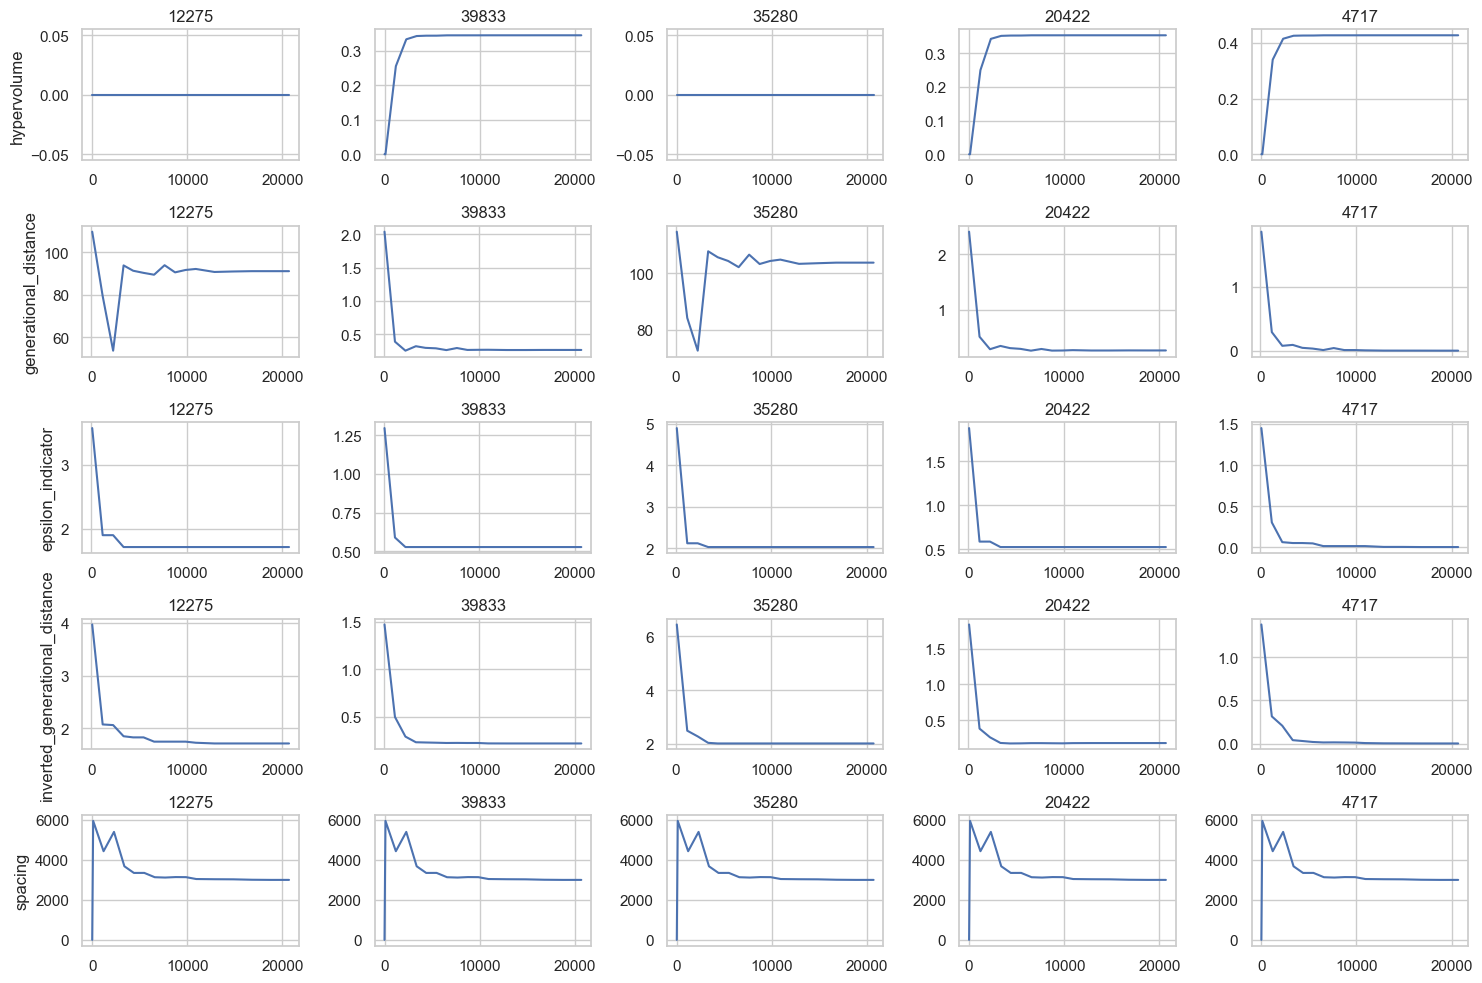

In [ ]:
# Define the list of metrics you want to plot
metrics_to_plot = ["hypervolume", "generational_distance", "epsilon_indicator", "inverted_generational_distance", "spacing"]

ax1, ax2, ax3, ax4, ax5, ax6 = axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

ax6.set_xlabel("nfe")


sns.despine(fig)

plt.show()